In [2]:
from google.colab import drive
drive.mount("/content/drive")
import shutil
from google.colab import files

Mounted at /content/drive


In [3]:
import cv2
import math
import os
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import matplotlib.colors as colors


In [4]:
data_path = "/content/drive/MyDrive/Location_Season_Data/"

In [5]:
df = pd.read_csv(data_path + "Location_Season_Pressure_first_3_year_ROI.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,season,Name,Day,Class
0,0.475692,0.473846,0.471385,0.468923,0.465846,0.462769,0.460308,0.456615,0.453538,0.450462,...,0.435077,0.443077,1,1,1,0,2,116_c7_cp2_100_32,116,0
1,0.464615,0.463385,0.462769,0.460923,0.460308,0.457846,0.455385,0.452923,0.451077,0.450462,...,0.454769,0.475077,1,0,1,0,2,125_c3_cp2_49_32,125,0
2,0.248615,0.243692,0.240000,0.237538,0.235692,0.234462,0.234462,0.235692,0.237538,0.240615,...,0.246154,0.264615,1,0,0,0,2,120_c1_cp2_31_29,120,0
3,0.552000,0.544000,0.536615,0.529846,0.524923,0.521846,0.520000,0.519385,0.520615,0.523077,...,0.475077,0.492923,1,1,1,0,2,127_c3_cp3_96_38,127,0
4,0.248615,0.243692,0.240000,0.237538,0.235692,0.234462,0.234462,0.235692,0.237538,0.240615,...,0.246154,0.264615,1,0,0,0,2,120_c2_cp2_31_29,120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,0.930833,0.935248,0.939601,0.937135,0.942242,0.940599,0.940394,0.935167,0.934217,0.936547,...,0.948077,0.953185,1,0,1,1,3,997_c12_cp2_62_59,997,3
1064,0.869459,0.873418,0.876279,0.877193,0.879589,0.879725,0.879310,0.874263,0.870889,0.869159,...,0.911058,0.919884,1,0,1,1,3,998_c12_cp2_37_48,998,2
1065,0.759864,0.772639,0.783731,0.791910,0.800783,0.806087,0.810837,0.810413,0.810015,0.810133,...,0.813462,0.813224,1,1,1,0,3,999_c11_cp2_102_34,999,2
1066,0.812957,0.820837,0.826595,0.829435,0.835047,0.838979,0.843350,0.843320,0.844379,0.848008,...,0.909615,0.921332,1,0,1,0,3,999_c11_cp3_37_44,999,2


In [6]:
df_train = df[(df["Day"] >= 0) & (df["Day"] <= 730)]
X_train = df_train.drop(columns = ["Name", "Day", "Class"])
Y_train = df_train["Class"]

df_test = df
X_test = df_test.drop(columns = ["Name", "Day", "Class"])
Y_test = df_test["Class"]

# **SOM**

In [7]:
#Normalization
def minmax_scaler(data):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return scaled
#Euclidean distance
def e_distance(x, y):
    return distance.euclidean(x, y)

#Manhanttan distance
def m_distance(x, y):
    return distance.cityblock(x, y)

#Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

#Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [16]:
num_rows = 25
num_cols = 25
max_m_dsitance = 8
max_learning_rate = 0.4
max_steps = 10000

In [17]:
#main function

train_x_norm = minmax_scaler(X_train) # normalisation
# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
# som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# Compute PCA on the normalized training data
pca = PCA(n_components=num_dims)  # You can adjust the number of components if needed
pca.fit(train_x_norm)

# Get the top principal components
top_components = pca.components_

# Initialize SOM using PCA components
som = np.zeros((num_rows, num_cols, num_dims))  # Initialize SOM with zeros
for row in range(num_rows):
  for col in range(num_cols):
    component_index = row * num_cols + col  # Calculate the index of the component
    if component_index < num_dims:  # Make sure the index is within bounds
      som[row, col] = top_components[component_index]
    else:
      # Handle the case where you have fewer components than SOM dimensions
      # You can choose to leave the weight as zeros or use a default value
      som[row, col] = np.random.random(num_dims)  # Example of using random values

# Optionally, you can scale the initialized SOM to have a unit norm
for row in range(num_rows):
  for col in range(num_cols):
    som[row, col] /= np.linalg.norm(som[row, col])

batch_size = 20 # Define your batch size

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  batch_indices = np.random.choice(train_x_norm.shape[0], batch_size, replace=False)

  for t in batch_indices:
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
      for col in range(num_cols):
        if m_distance([row, col], winner) <= neighbourhood_range:
          som[row][col] += learning_rate * (train_x_norm[t] - som[row][col])

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
SOM training completed


In [18]:
label_data = np.array(Y_train)
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

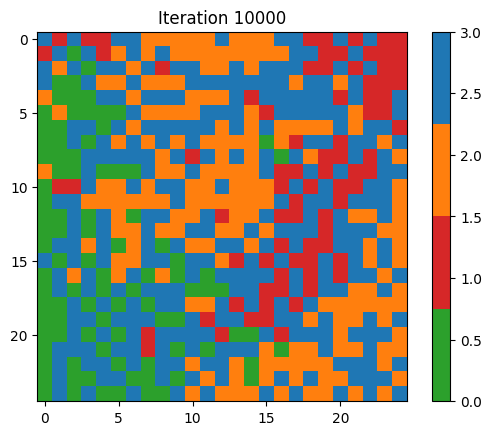

In [19]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 3
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange', 'tab:blue'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [20]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data_frame = minmax_scaler(X_test) # normalisation

winner_labels = []
pre_labels = []

for t in range(data_frame.shape[0]):
  winner = winning_neuron(data_frame, t, som, num_rows, num_cols)
  row = winner[0]
  col = winner[1]
  predicted = label_map[row][col]
  winner_labels.append(predicted)

In [21]:
print("Accuracy: ", accuracy_score(np.array(winner_labels), np.array(Y_test)))

Accuracy:  0.7846441947565543


In [22]:
print(confusion_matrix(np.array(winner_labels), np.array(Y_test)))

[[217   5  18   0]
 [ 12 189   3  13]
 [ 13  22 350  52]
 [ 25  24  43  82]]


In [23]:
df["Label"] = winner_labels
third_test = df[(df["Day"] >= 731) & (df["Day"] <= 1095)]
print("Accuracy: ", accuracy_score(np.array(third_test["Label"]), np.array(third_test["Class"])))


Accuracy:  0.42900302114803623


In [24]:
first_two = df[df["Day"] < 731]
print("Accuracy: ", accuracy_score(np.array(first_two["Label"]), np.array(first_two["Class"])))

Accuracy:  0.9443690637720489
